:warning:**IMPORTANT NOTICE**:warning:\
*Since the initial parameterisation and gradient descent optimisation are stochastic processes, the training of a neural network is not fully reproducible.*

*Therefore, it is not recommended to re-run this script as it will overwrite the original calibration of the neural network used in the work presented here.
The purpose of this script is solely to document the training procedure and can be copied as a template to fit other new neural networks.*

*To experiment with the models calibrated here, they can be loaded from the `saved_models` directory.*

# **Biotite Thermobarometer**: Direct fit on natural biotite composition data + Index minerals

This notebook is used for the final model fitting of a biotite thermobarometer based on bioite compositional data from the databse of Pattison & Forshaw (in prep.).\
Additionally, index minerals in the biotite-bearing rocks are used as an input feature of the model. The following index minerals are considered: chlorite, garnet, cordierite, staurolite, andalusite, kyanite, sillimanite and k-feldspar.\

Based on hyperparameter optimisation and feature engineering the following dataset and hyperparameters were selected:

**Data**:\
Elements [apfu] of the biotite solution models: Si, Ti, Al, Fe, Mg, Mn\
Feature engineering showed no significant performance improvement when including Na & K

Index minerals:\
chlorite, garnet, cordierite, staurolite, andalusite, kyanite, sillimanite and k-feldspar\
Feature engineering has shown no significant increase in performance including Fe-Ti minerals.

*Normalisation*:
- Normalisation of compositional input data [-1, 1], input normalisation parameters (mean + std) are learned from the training data.
- One-hot encoding of index minerals, no normalisation required.
- MinMaxScaler for target data (*P*-*T*) [0, 1], traget scaling parameters (min + max) are hard-coded to the range of the training data: *P* [1500, 10000] [bar] and *T* [400, 900] [°C].

**Hyperparameters**:
- Architecture: "huge" (3 hidden layer with 64 neurons), best validation performance for *T* and *P*
- Learning rate: 0.001, all lr resulted in similar performance only training duration varied, 0.001 was chosen for faster training while keeping lr small\
- Regularisation: Dropout layers (0.2)

⚠️ *Note*:\
2 models were tested for the final model fitting, based on the hyperparam tests:
- A simple model with a (16) architecture and no additional regularization
---> This model performed statistically good, but predicted "outliers" (espiecially for *P*: negative predictions). Most likely it relied too much on certain mineral presence or absence.
- A complex model with a (64, 64, 64) architecture and dropout layers
--> we interpret that the additon of dropout layers helped to get rid of the "outliers" in the predictions.


*Parameters not systematically tested*:
- Activation function: "relu", not systematically tested, but no effect in exploratory tests
- Optimizer: "adam"
- Loss function: "mean_squared_error", given by regression task
- Lr scheduler: Inverse time decay
- Batch size: 50



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Normalization, BatchNormalization, LayerNormalization, Dropout
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, schedules
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras.callbacks import CSVLogger, EarlyStopping
from sklearn.model_selection import train_test_split

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import rootmeansquarerror_temperature_denormalised, rootmeansquarerror_pressure_denormalised
from ml_tb.plot import plot_training_curve, prediction_vs_truth

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_16836\4009084104.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import data, pre-procesing and train/test split

Validation set is **10%** of the training set. Approx. 100 samples. Validation fraction is reduced to keep the training set as large as possible. Witht the set of hyperparameters obtained by hyperparameter optimisation, overfittings should be kept to a minimum.

In [2]:
VALIDATION_FRACTION = 0.1

Global scaling parameters for MinMaxScaling of the target data are hard-coded to the range of the training data.

In [3]:
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

In [4]:
# load excel file
data = pd.read_excel(Path("Metapelite-Database_Bt_CLEAN_2024-02-03.xlsx"))

biotite_composition = np.zeros(shape=(len(data), 6))
biotite_composition[:, 0] = data["Bt-Si"]
biotite_composition[:, 1] = data["Bt-Ti"]
biotite_composition[:, 2] = data["Bt-Al"]
biotite_composition[:, 3] = data["Bt-FeTot"]
biotite_composition[:, 4] = data["Bt-Mn"]
biotite_composition[:, 5] = data["Bt-Mg"]

# extract one-hot encoded minerals in the following order: Chl, Grt, Crd, And, St, Ky, Sil, Kfs
index_minerals = np.zeros(shape=(len(data), 8))
index_minerals[:, 0] = data["Chl"]
index_minerals[:, 1] = data["Grt"]
index_minerals[:, 2] = data["Crd"]
index_minerals[:, 3] = data["And"]
index_minerals[:, 4] = data["St"]
index_minerals[:, 5] = data["Ky"]
index_minerals[:, 6] = data["Sil"]
index_minerals[:, 7] = data["Kfs"]

# Some minerals (Chl, Grt, St) have NaN values. Replace them with 0. Most likely samples with regional or metastable phases?!
index_minerals = np.nan_to_num(index_minerals, nan=0)

# combine biotite composition and one-hot encoded minerals
biotite_composition_idxmin = np.concatenate((biotite_composition, index_minerals), axis=1)

pt = np.zeros(shape=(len(data), 2))
pt[:, 0] = data["Pressure estimate random uniform"] * 1000 # convert to bar
pt[:, 1] = data["Temperature random ordered after Ti-in-Bt"]

# check for NaN values (should be already filtered out)
print("NaN values in biotite composition: ", np.isnan(biotite_composition_idxmin).any())
print("NaN values in PT: ", np.isnan(pt).any())

NaN values in biotite composition:  False
NaN values in PT:  False


In [5]:
# test train split
data_train, data_val, pt_train, pt_val = train_test_split(biotite_composition_idxmin, pt, test_size=VALIDATION_FRACTION, shuffle=True)

# NORMALISATION
normalisation_biotite_composition = Normalization(axis=-1)
normalisation_biotite_composition.adapt(data_train)

# the one-hot encoded minerals should not be normalised. This is not necessary, as they are already in the range [0, 1]
# Set the mean and variance to 0 and 1, respectively
norm_mean = normalisation_biotite_composition.mean.numpy()
norm_mean[0,-8:] = 0
norm_var = normalisation_biotite_composition.variance.numpy()
norm_var[0,-8:] = 1
normalisation_biotite_composition.mean = tf.convert_to_tensor(norm_mean)
normalisation_biotite_composition.variance = tf.convert_to_tensor(norm_var)

print(normalisation_biotite_composition.mean.numpy())
print(np.sqrt(normalisation_biotite_composition.variance.numpy()))

# SCALING of PT
pt_train_norm = scaling_pt(pt_train)
pt_val_norm = scaling_pt(pt_val)

print("After scaling, the minimal values of P and T are: ", np.min(pt_train_norm, axis=0))
print("After scaling, the maximal values of P and T are: ", np.max(pt_train_norm, axis=0))

[[2.70771    0.12064927 1.7103409  1.2296611  0.00848337 1.0905079
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]
[[0.04726482 0.047674   0.09382845 0.22844881 0.00727573 0.2611914
  1.         1.         1.         1.         1.         1.
  1.         1.        ]]
After scaling, the minimal values of P and T are:  [0.00010304 0.00066034]
After scaling, the maximal values of P and T are:  [0.940462  0.8988128]


## Set-up global training parameters

Define a function to calculate RMSE for pressure and temperature for unscaled values to have an interpretable metric.

In [6]:
def RMSE_P(y_true, y_pred):
    return rootmeansquarerror_pressure_denormalised(y_true, y_pred, inv_scaling_pt)


def RMSE_T(y_true, y_pred):
    return rootmeansquarerror_temperature_denormalised(y_true, y_pred, inv_scaling_pt)

In [7]:
BATCH_SIZE = 50
STEPS_PER_EPOCH = len(data_train) // BATCH_SIZE
MAX_EPOCHS = 5000

lr_schedule = schedules.InverseTimeDecay(0.001, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)

LOSS = MeanSquaredError()
METRICS = [MeanAbsoluteError(), RootMeanSquaredError(), RMSE_P, RMSE_T]
OPT = Adam(lr_schedule)

CALLBACKS = [CSVLogger("01b_BtThermobaromater_composition.log"), EarlyStopping(monitor="loss", patience=50, restore_best_weights=True)]

### Build model

In [8]:
model = Sequential()
model.add(normalisation_biotite_composition)
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2))

model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 14)                29        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                960       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                        

### Train model

In [9]:
history = model.fit(data_train, pt_train_norm,
                    validation_data=(data_val, pt_val_norm),
                    batch_size=BATCH_SIZE,
                    epochs=MAX_EPOCHS,
                    callbacks=CALLBACKS)

model.save(Path("saved_models", "01b_BtThermobaromater_composition"))

Epoch 1/5000


39/39 [==============================] - 2s 10ms/step - loss: 0.0667 - mean_absolute_error: 0.1979 - root_mean_squared_error: 0.2582 - RMSE_P: 1746.4897 - RMSE_T: 95.1649 - val_loss: 0.0204 - val_mean_absolute_error: 0.1052 - val_root_mean_squared_error: 0.1429 - val_RMSE_P: 953.5443 - val_RMSE_T: 49.1165
Epoch 2/5000
39/39 [==============================] - 0s 3ms/step - loss: 0.0333 - mean_absolute_error: 0.1385 - root_mean_squared_error: 0.1824 - RMSE_P: 1188.9672 - RMSE_T: 68.5158 - val_loss: 0.0159 - val_mean_absolute_error: 0.0908 - val_root_mean_squared_error: 0.1259 - val_RMSE_P: 840.0996 - val_RMSE_T: 41.4311
Epoch 3/5000
39/39 [==============================] - 0s 3ms/step - loss: 0.0235 - mean_absolute_error: 0.1169 - root_mean_squared_error: 0.1533 - RMSE_P: 1021.1570 - RMSE_T: 56.7926 - val_loss: 0.0155 - val_mean_absolute_error: 0.0895 - val_root_mean_squared_error: 0.1247 - val_RMSE_P: 774.3307 - val_RMSE_T: 43.9692
Epoch 4/5000
39/39 [====================

INFO:tensorflow:Assets written to: saved_models\01b_BtThermobaromater_composition\assets


# Plot training history

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Temperature RMSE [K]'>,
        <Axes: xlabel='Epoch', ylabel='Pressure RMSE [bar]'>], dtype=object))

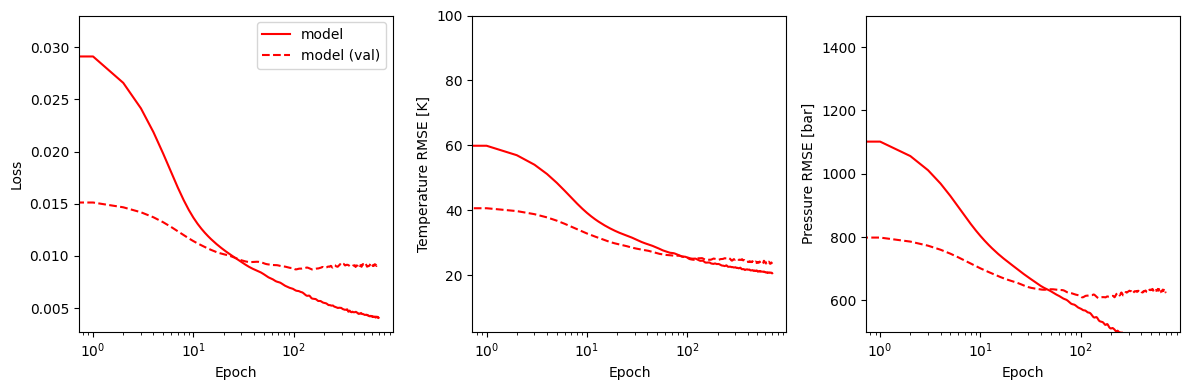

In [10]:
plot_training_curve("01b_BtThermobaromater_composition.log", color="red", label="model", log_scale=True, ylims=[None, (2.5, 100), (500, 1500)])

7/7 [==============================] - 0s 1ms/step


(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='True pressure [bar]', ylabel='Predicted pressure [bar]'>,
        <Axes: xlabel='True temperature [°C]', ylabel='Predicted temperature [°C]'>],
       dtype=object))

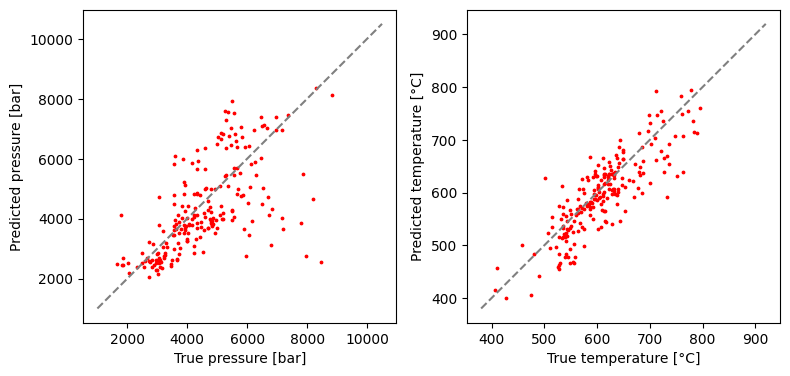

In [11]:
y_true = pt_val
y_pred = inv_scaling_pt(model.predict(data_val))

color = "red"

prediction_vs_truth(y_true, y_pred, color)
